BlockSeparation+NonLinearEncoder+UNetdecoder(Lighten:**ResidualBlock**)

4*4kernel,1:8,

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time

In [2]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data02', 'MNIST_AE[004]_Res1_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)

1216
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data02/MNIST_AE[004]_Res1_result


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)
batch_size = 100 #
train_dataloader = DataLoader(mnist_train,batch_size,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size,shuffle=False)

In [5]:
def ssim_loss(img1, img2):

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 ** 2, kernel_size=3, stride=1, padding=1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, kernel_size=3, stride=1, padding=1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1)*(2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [6]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size)

    return kernels

In [7]:
#Encoder5DX
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,alpha=0.6):
        super(Encoder, self).__init__()

        self.kernel_size = kernel_size
        self.kernel_in = int(kernel_size**2)
        self.leverage = leverage
        real_part = nn.Parameter(torch.randn(int(self.kernel_in/leverage), self.kernel_in)*(1/np.sqrt(self.kernel_in)))
        imag_part = nn.Parameter(torch.randn(int(self.kernel_in/leverage), self.kernel_in)*(1/np.sqrt(self.kernel_in)))
        self.B = torch.complex(real_part, imag_part).detach()
        self.B.requires_grad = False

        self.alpha = alpha
    

    def forward(self, x):
        b, n_x, k, _ = x.shape
        x = x.view(b*n_x,-1)
        x = torch.exp(1j*self.alpha*x)
        x=x.T#[16,4900]
        x = torch.matmul(self.B, x).T#[4900, 2]
        x = torch.abs(x) ** 2
        x = x.reshape(b,-1)#[100, 49,2]
        return x

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, groups=1):
        super(ResidualBlock, self).__init__()
        # Convを1回のみに縮小
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False)
        # BatchNormの代わりに、より軽量なGroupNormを使用
        # group=1とすると実質LayerNormに近い効果を得ることもできます。
        self.norm = nn.GroupNorm(groups, out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

        # in/outチャネル数が異なる場合のみshortcutを追加
        # Conv1x1で次元合わせを実行
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = self.norm(out)

        # shortcutありの場合、residualのチャネル数を変換
        if self.shortcut is not None:
            residual = self.shortcut(residual)

        out += residual
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch):
        super(UNetDecoder, self).__init__()

        self.ch = ch
        self.fc = nn.Linear(num_in, ch*7*7)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 1, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, self.ch, 7, 7) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self,DofIN,kernel_size,leverage,ch):
        super(AutoEncoder, self).__init__()

        self.kernel_size = kernel_size
        self.encoder = Encoder(kernel_size,leverage)  
        self.decoder = UNetDecoder(int(DofIN/leverage),ch)

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)  
        x = split_into_kernels(x,self.kernel_size)
        latent = self.encoder(x) 
        x_reconstructed = self.decoder(latent)
        return x_reconstructed

In [10]:
DofIN = 784 ##
leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 40

num_N = DofIN/leverage

model = AutoEncoder(DofIN,kernel_size,leverage,ch)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
loss_train_ = []
loss_test_ = []
pro_time = []

max_epochs = 10
for epoch in range(max_epochs):
    loss_train = 0
    loss_test = 0
    ssim_sum = 0

    start_time = time.time()
    for (x,t) in train_dataloader:

        sys.stderr.write('\rEpoch: %d/%d' % (epoch, max_epochs)) 
        sys.stderr.flush()
        
        y = model(x)
        loss = criterion(y.view(y.size(0), -1), x.view(x.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    end_time = time.time()
       
    loss_train_avg = loss_train / len(train_dataloader)

    with torch.no_grad():
        for x, t in test_dataloader:
            y = model(x)
            loss = criterion(y.view(y.size(0), -1), x.view(x.size(0), -1))
            loss_test += loss.item()
            if epoch == max_epochs-1:
                ssim = ssim_loss(y.view(-1, 1, 28, 28),x.view(-1, 1, 28, 28))
                ssim_sum += ssim.item()

    loss_test_avg = loss_test / len(test_dataloader)

    loss_train_.append(loss_train_avg)
    loss_test_.append(loss_test_avg)
    pro_time.append(end_time-start_time)

ssim_test = ssim_sum/len(test_dataloader)


Epoch: 9/10

In [12]:

Last_loss_train = loss_train_[-1]
Last_loss_test = loss_test_[-1]

print('Train Last MSE: ',Last_loss_train)
print('Test Last MSE:  ',Last_loss_test)
print('Test Last SSIM: ',ssim_test)
print('processing Time:',sum(pro_time))

Train Last MSE:  0.016115594130630295
Test Last MSE:   0.01627398273907602
Test Last SSIM:  0.7989511013031005
processing Time: 814.1220848560333


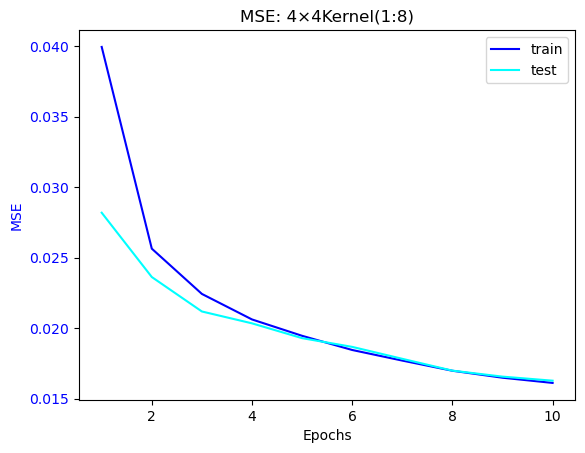

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d×%dKernel(1:%d)'%(kernel_size,kernel_size,leverage) ##
plt.title(title)
plt.legend()
file_name = '%d_%d%dKernel(1:%d).png'%(int(formatted_date),kernel_size,kernel_size,leverage)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

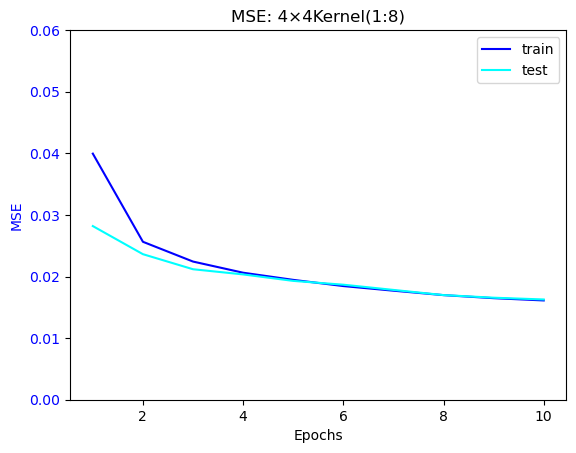

In [14]:
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.ylim(0,0.06)
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d×%dKernel(1:%d)'%(kernel_size,kernel_size,leverage) ##
plt.title(title)
plt.legend()
file_name = '%d_%d%dKernel(1:%d)_ex.png'%(int(formatted_date),kernel_size,kernel_size,leverage)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

In [15]:
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] 
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

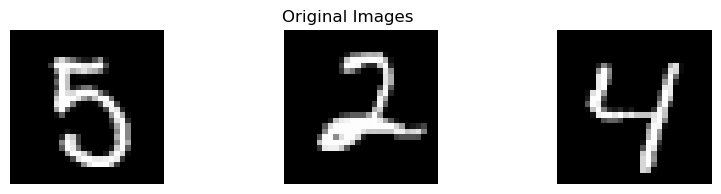

In [16]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:
        break
show_images(test_images, test_labels,"Original Images")

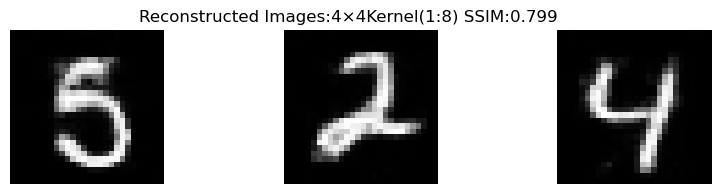

In [17]:
with torch.no_grad():
    reconstructed_images = model(test_images)
    show_images(reconstructed_images,test_labels, "Reconstructed Images:%d×%dKernel(1:%d) SSIM:%.3f"%(kernel_size,kernel_size,leverage,ssim_test))
    file_name = '%d_ReImage%d×%dKernel(1:%d).png'%(int(formatted_date),kernel_size,kernel_size,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

In [18]:
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data004ex','texts_sim') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[004]_Res1_list.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(loss_test_)

/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data004ex/texts_sim
